In [1]:
from gerrychain import Graph

In [2]:
# Read Iowa county graph from the json file "IA_county.json"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

import math
k = 4          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 793605 and U = 801580 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-14


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1716 rows, 1458 columns and 6990 nonzeros
Model fingerprint: 0xe75d93b4
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.02s
Presolved: 1716 rows, 1458 columns, 6990 nonzeros
Variable types: 444 continuous, 1014 integer (1014 binary)

Root relaxation: objective 0.000000e+00, 756 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  412          -    0.00000      -     -    0s
     0     0    0.13

 230318 191210   34.15505   42  236          -   22.65632      -  89.3  425s
 233228 193837   25.91665   28  426          -   22.67995      -  89.3  430s
*235788 57221              67      41.0000000   22.70068  44.6%  89.3  434s
 236339 56859     cutoff  100        41.00000   22.70306  44.6%  89.4  436s
H236378 45826                      39.0000000   22.70306  41.8%  89.4  436s
 237454 46896   34.74379   34  363   39.00000   22.74795  41.7%  89.5  440s
 240214 48212   25.92475   29  338   39.00000   22.84803  41.4%  89.7  447s
H241285 43862                      38.0000000   22.88615  39.8%  89.8  449s
 241460 44106   32.01178   39  254   38.00000   22.90232  39.7%  89.8  452s
H241510 39523                      37.0000000   22.90518  38.1%  89.8  452s
 241903 39727   28.62009   24  429   37.00000   22.91606  38.1%  89.8  455s
H242009 31196                      35.0000000   22.92282  34.5%  89.9  455s
H242298 23594                      33.0000000   22.93364  30.5%  89.9  459s
 242404 23

 426571 71916     cutoff   37        33.00000   26.07960  21.0%  97.8  950s
 429072 72377   30.07987   33  417   33.00000   26.10348  20.9%  97.8  956s
 430771 72708     cutoff   32        33.00000   26.11835  20.9%  97.9  960s
 432969 73166   31.48018   37  323   33.00000   26.13815  20.8%  97.9  966s
 434604 73449   31.45622   29  436   33.00000   26.15166  20.8%  97.9  970s
 437183 73927   29.30585   29  391   33.00000   26.17100  20.7%  97.9  976s
 438751 74292   30.50478   34  371   33.00000   26.18612  20.6%  98.0  980s
 441244 74740     cutoff   34        33.00000   26.20705  20.6%  98.0  985s
 443625 75120   31.70713   35  401   33.00000   26.22356  20.5%  98.0  991s
 446031 75507   31.61948   36  213   33.00000   26.24250  20.5%  98.0  996s
 448226 75897   30.59170   29  443   33.00000   26.25744  20.4%  98.1 1002s
 449694 76235   29.71667   34  356   33.00000   26.26962  20.4%  98.1 1006s
 452298 76625   31.58981   29  344   33.00000   26.28794  20.3%  98.1 1011s
 453986 7687

 652927 102549   31.56633   34  238   33.00000   27.43918  16.9%  98.8 1491s
 655328 102761     cutoff   40        33.00000   27.45161  16.8%  98.8 1496s
 657007 102897   29.75270   30  453   33.00000   27.45896  16.8%  98.8 1500s
 659480 103180     cutoff   33        33.00000   27.47037  16.8%  98.8 1506s
 661272 103311   29.13562   36  326   33.00000   27.47760  16.7%  98.8 1510s
 663813 103489   30.28539   33  225   33.00000   27.48889  16.7%  98.8 1516s
 665341 103613   31.37993   32  302   33.00000   27.49679  16.7%  98.8 1520s
 667834 103810   29.02248   34  353   33.00000   27.50792  16.6%  98.8 1526s
 670399 104075   28.78937   34  379   33.00000   27.51693  16.6%  98.8 1531s
 671861 104201   30.35330   40  334   33.00000   27.52379  16.6%  98.8 1535s
 674401 104401   31.35576   34  303   33.00000   27.53390  16.6%  98.8 1540s
 676987 104626   31.31960   38  361   33.00000   27.54488  16.5%  98.8 1545s
 678558 104721   29.00116   40  357   33.00000   27.55238  16.5%  98.8 1550s

 894094 114370   31.02296   29  351   33.00000   28.36879  14.0%  97.7 2025s
 896849 114366     cutoff   32        33.00000   28.37807  14.0%  97.6 2031s
 899423 114416     cutoff   31        33.00000   28.38775  14.0%  97.6 2036s
 901245 114403   30.15542   30  408   33.00000   28.39421  14.0%  97.6 2040s
 903798 114438     cutoff   30        33.00000   28.40224  13.9%  97.6 2045s
 906555 114412   29.87806   29  409   33.00000   28.41230  13.9%  97.6 2051s
 908330 114427   31.50240   31  404   33.00000   28.42041  13.9%  97.6 2055s
 910914 114421     cutoff   31        33.00000   28.42916  13.9%  97.6 2061s
 913607 114422   30.88304   33  410   33.00000   28.43966  13.8%  97.5 2066s
 915494 114422   29.26151   29  421   33.00000   28.44627  13.8%  97.5 2070s
 918049 114434     cutoff   35        33.00000   28.45499  13.8%  97.5 2075s
 920676 114415     cutoff   32        33.00000   28.46469  13.7%  97.5 2080s
 923156 114464   30.04740   35  297   33.00000   28.47317  13.7%  97.4 2085s

 1149496 104434   30.92937   39  288   33.00000   29.20485  11.5%  95.8 2555s
 1152330 104178     cutoff   36        33.00000   29.21394  11.5%  95.8 2561s
 1154236 103994     cutoff   31        33.00000   29.21979  11.5%  95.7 2565s
 1157063 103714     cutoff   25        33.00000   29.22917  11.4%  95.7 2570s
 1159732 103445     cutoff   39        33.00000   29.23781  11.4%  95.7 2576s
 1162560 103158   31.84575   41  241   33.00000   29.24692  11.4%  95.7 2581s
 1164451 103004     cutoff   36        33.00000   29.25270  11.4%  95.7 2585s
 1167086 102708     cutoff   32        33.00000   29.26116  11.3%  95.6 2591s
 1169946 102437   31.07337   34  426   33.00000   29.26976  11.3%  95.6 2596s
 1172609 102208   31.84482   32  314   33.00000   29.27903  11.3%  95.6 2601s
 1174573 102011     cutoff   32        33.00000   29.28517  11.3%  95.6 2605s
 1177494 101696   31.48268   31  327   33.00000   29.29478  11.2%  95.6 2611s
 1179373 101509     cutoff   29        33.00000   29.30025  11.2

 1424459 58022   30.61530   39  284   33.00000   30.21316  8.44%  93.5 3091s
 1427482 57230     cutoff   30        33.00000   30.22781  8.40%  93.4 3096s
 1429258 56635   31.80937   41  202   33.00000   30.23694  8.37%  93.4 3100s
 1432039 55781     cutoff   30        33.00000   30.25093  8.33%  93.4 3105s
 1433042 55703   31.76995   31  344   33.00000   30.25616  8.31%  93.4 3110s
 1435277 54886     cutoff   36        33.00000   30.26631  8.28%  93.3 3116s
 1438241 54045   31.87299   31  349   33.00000   30.28128  8.24%  93.3 3121s
 1441004 53231   31.39139   33  366   33.00000   30.29548  8.20%  93.3 3126s
 1443069 52628   31.90335   36  365   33.00000   30.30511  8.17%  93.3 3130s
 1446074 51722   31.14467   39  305   33.00000   30.31897  8.12%  93.2 3135s
 1449894 50601     cutoff   37        33.00000   30.34011  8.06%  93.2 3141s
 1452674 49753   31.09122   28  371   33.00000   30.35395  8.02%  93.1 3146s
 1455478 48851     cutoff   35        33.00000   30.36923  7.97%  93.1 3150s

In [11]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 797302 and contains counties ['Wright', 'Story', 'Sac', 'Hardin', 'Boone', 'Plymouth', 'Cherokee', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Cerro Gordo', 'Greene', 'Lyon', 'Monona', 'Humboldt', 'Hamilton', 'Franklin', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Carroll', 'Pocahontas', 'Kossuth', 'Webster', 'Palo Alto', 'Calhoun', 'Worth', 'Hancock', 'Dickinson', 'Buena Vista', 'Dallas']

District 1 has population 798068 and contains counties ['Montgomery', 'Union', 'Polk', 'Audubon', 'Pottawattamie', 'Taylor', 'Page', 'Fremont', 'Adams', 'Cass', 'Decatur', 'Harrison', 'Madison', 'Ringgold', 'Clarke', 'Warren', 'Adair', 'Shelby', 'Mills']

District 2 has population 796929 and contains counties ['Keokuk', 'Marshall', 'Davis', 'Jasper', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Monroe', 'Muscatine', 'Lucas', 'Washington', 'Cedar', 'Jefferson', 'Poweshiek', 'Wayne', 'Marion', 'Mahaska',

In [12]:
# To solve the MIP faster, let's fix some district roots:

r[8,1].LB = 1  # Fix Polk County as root of district 0
r[88,3].LB = 1 # Fix Linn County as root of district 1
r[25,2].LB = 1  # Fix Scott County as root of district 2

m.reset()      # Force Gurobi to start solving 'from scratch'
m.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1716 rows, 1458 columns and 6990 nonzeros
Model fingerprint: 0x77044993
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 366 rows and 327 columns
Presolve time: 0.02s
Presolved: 1350 rows, 1131 columns, 5574 nonzeros
Variable types: 444 continuous, 687 integer (687 binary)

Root relaxation: objective 1.181523e+01, 1116 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.81523

 132893 11367     cutoff   29        33.00000   29.72711  9.92%   137  386s
 134634 10886   31.68987   29  353   33.00000   29.79397  9.72%   137  391s
 136320 10420     cutoff   25        33.00000   29.88832  9.43%   137  395s
 138057  9896     cutoff   30        33.00000   29.96628  9.19%   137  400s
 140710  9044     cutoff   21        33.00000   30.10174  8.78%   137  406s
 142440  8380     cutoff   26        33.00000   30.19414  8.50%   137  410s
 145348  7418     cutoff   25        33.00000   30.35471  8.02%   136  416s
 146918  6703     cutoff   38        33.00000   30.43431  7.77%   136  420s
 150033  5423   31.97124   32  123   33.00000   30.60998  7.24%   135  426s
 152142  4426     cutoff   33        33.00000   30.74694  6.83%   135  430s
 155289  2735     cutoff   47        33.00000   31.00661  6.04%   134  435s

Cutting planes:
  Flow cover: 11
  RLT: 133

Explored 159847 nodes (21213426 simplex iterations) in 439.99 seconds (525.23 work units)
Thread count was 8 (of 8 ava

In [13]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 799340 and contains counties ['Wright', 'Montgomery', 'Union', 'Sac', 'Audubon', 'Hardin', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Cerro Gordo', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', 'Hamilton', 'Franklin', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Decatur', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Palo Alto', 'Ringgold', 'Calhoun', 'Worth', 'Adair', 'Hancock', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills']

District 1 has population 795249 and contains counties ['Story', 'Polk', 'Marshall', 'Boone', 'Jasper', 'Dallas']

District 2 has population 797710 and contains counties ['Keokuk', 'Davis', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Monroe', 'Muscatine', 'Lucas', 'Washington', 'Cedar', 'Jefferson', 'Madison', 'Clarke', 'Warren', 'Poweshiek', 'Wayne', 'Marion', 'Mahaska',

In [14]:
# Let's draw it on a map
import geopandas as gpd

In [15]:
# Read Iowa county shapefile from "IA_county.shp"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

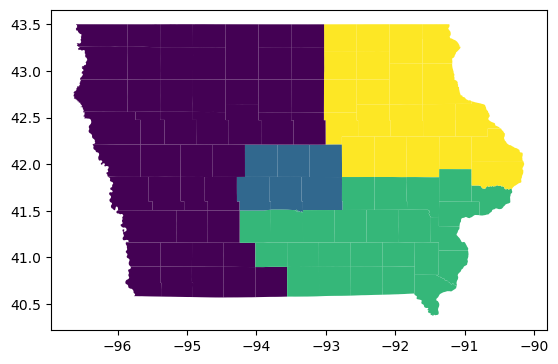

In [16]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()